In [12]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
from IPython import get_ipython


  # DFT and FFT
  ## Discrete Fourier Transform (DFT)
  Following \[1,2\], the *Discrete Fourier Transform* (DFT) transforms a sequence of $N$ complex numbers $\left\{\mathrm{x}_{\mathrm{n}}\right\}:=x_{0}, x_{1}, \ldots, x_{N-1}$ into another sequence of complex numbers, $\left\{\mathrm{X}_{\mathrm{k}}\right\}:=X_{0}, X_{1}, \ldots, X_{N-1}$ and is defined by:
  \begin{equation}
    X_{k}=\sum_{n=0}^{N-1} x_{n} \cdot e^{-\frac{i 2 \pi}{N} k n}
  \end{equation}
  The *Inverse Discrete Fourier Transform* (IDFT) is defined by:
  $$
    x_{n}=\frac{1}{N} \sum_{k=0}^{N-1} X_{k} \cdot e^{\frac{i 2 \pi}{N} k n}
  $$

  \[1\]: https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/

  \[2\]: https://en.wikipedia.org/wiki/Discrete_Fourier_transform

  ## Comparison to Lecture
  In the lecture, the vector of coefficients $\hat{y} := \left\{d_0,\dots,d_{N-1}\right\}$ with
  \begin{equation}
    d_j = \frac{1}{N} \sum_{k=0}^{N-1} y_k e^{-j i x_k} \quad \text{ for } j=0 \ldots N-1
  \end{equation}
  was defined as the DFT. However, we use the more common definition given above for this lab.

  ## Packages
  - `IPython.display`: jupyter usage
  - `numpy`: numeric calculations
  - `matplotlib`: plotting
  - `math`: for Python's mathematics functions
  - `time`: for timings

In [13]:
# Packages
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import math
import time


  ### Discrete Fourier Transform as Linear Operation
  We can write the DFT
  \begin{equation}
    X_{k}=\sum_{n=0}^{N-1} x_{n} \cdot e^{-\frac{i 2 \pi}{N} k n}
  \end{equation}
  as linear operation (matrix-vector multiplication) using
  \begin{equation}
    \mathrm{X} = \mathrm{M} \cdot \mathrm{x}
  \end{equation}
  where the matrix $\mathrm{M}$ is given by
  \begin{equation}
    (\mathrm{M})_{k,n} = e^{-\frac{i 2 \pi}{N} k n}
  \end{equation}
  The IDFT
  $$
    x_{n}=\frac{1}{N} \sum_{k=0}^{N-1} X_{k} \cdot e^{\frac{i 2 \pi}{N} k n}
  $$
  can also be written as linear operation using
  $$
  \mathrm{x} = \mathrm{m} \cdot \mathrm{X}
  $$
  where the matrix $\mathrm{m}$ is given by
  \begin{equation}
    (\mathrm{m})_{n,k} = \frac{1}{N} e^{\frac{i 2 \pi}{N} k n}
  \end{equation}
  Note that $\mathrm{m} = (\mathrm{M})^{-1} = \frac{1}{N} \mathrm{\overline{M}}^T$ (switched indices $k,n \mapsto n,k$ and complex conjugation $\overline{-i} \mapsto i $).

In [14]:
# Implement DFT and IDFT

def DFT(x):
    x = np.asarray(x, dtype=complex)
    N = x.shape[0]
    n = np.arange(N) # n = [0,...,N-1] (rows)
    k = n.reshape((N, 1)) # k = [[0],...,[N-1]] (cols)
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

def IDFT(X):
    X = np.asarray(X, dtype=complex)
    N = X.shape[0]
    k = np.arange(N) # n = [0,...,N-1] (rows)
    n = k.reshape((N, 1)) # k = [[0],...,[N-1]] (cols)
    m = 1/N * np.exp(2j * np.pi * k * n / N)
    return np.dot(m, X)

# Validation
# - Last weeks interpolation task [2,0,2,0] should give coeffs [1,0,1,0]
# - IDFT(IDFT(x)) == x
# - np.fft.fft(x) == DFT(x)

x = [2,0,2,0]
assert np.allclose(IDFT(x), [1,0,1,0])
x = np.random.rand(2**5)
assert np.allclose(IDFT(DFT(x)), x)
assert np.allclose(DFT(x), np.fft.fft(x))
assert np.allclose(IDFT(x), np.fft.ifft(x))
print("IDFT([2,0,2,0]) = [1,0,1,0] = ", IDFT([2,0,2,0]))
print("IDFT(DFT([2,0,2,0])) = [2,0,2,0] = ", IDFT(DFT([2,0,2,0])))


IDFT([2,0,2,0]) = [1,0,1,0] =  [1.+0.0000000e+00j 0.+6.1232340e-17j 1.-1.2246468e-16j 0.+1.8369702e-16j]
IDFT(DFT([2,0,2,0])) = [2,0,2,0] =  [ 2.0000000e+00-1.22464680e-16j -1.2246468e-16+2.99951957e-32j
  2.0000000e+00+1.22464680e-16j  1.2246468e-16+2.44929360e-16j]


In [15]:
np.round(IDFT(DFT([2,0,2,0])).real)

array([ 2., -0.,  2.,  0.])

  ## Fast Fourier Transform (FFT)
  TODO: Explain derivation

In [16]:
# Implement FFT and IFFT
# Validate with DFT (question from lecture: there's no approx made!)

def FFT(x, cutoff=1):
    x = np.asarray(x, dtype=complex)
    N = x.shape[0]
    assert math.log2(N).is_integer()
    if N <= 1:
        return [x[0]]
    else:
        M = N//2
        x_even = [(x[k]+x[k+M]) for k in range(M)]
        x_odd = [(x[k]-x[k+M]) for k in range(M)]
        factor = [np.exp(-2*np.pi*1j*k/N) for k in range(M)]
        a = FFT(x_even) #! Note: Lecture has 1/2 here, cf. starting paragraph
        b = FFT(np.multiply(factor,x_odd))
        result = np.empty(len(a)+len(b), dtype=complex)
        result[::2] = a # even entries
        result[1::2] = b # odd entries
        return result # result = [a_0,b_0,...,a_M,b_M]

def IFFT(X):
  raise NotImplementedError

x = np.random.rand(2**5)
assert np.allclose(FFT(x), DFT(x))
print("np.allclose(FFT(x), DFT(x)) = ", np.allclose(FFT(x), DFT(x)))



np.allclose(FFT(x), DFT(x)) =  True


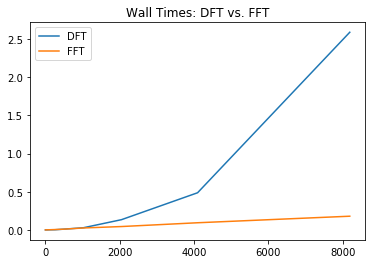

In [17]:
# Comparing the timings of DFT vs. FFT
N = 14
dft_times = np.empty(N)
fft_times = np.empty(N)
for i in range(N):
    # print("calculate i = ", i)
    x = np.random.rand(2**i)
    time1 = time.time()
    DFT(x)
    time2 = time.time()
    dft_times[i] = time2-time1
    time3 = time.time()
    FFT(x)
    time4 = time.time()
    fft_times[i] = time4-time3
dofs = [2**i for i in range(N)]
plt.plot(dofs, dft_times, dofs, fft_times)
plt.title("Wall Times: DFT vs. FFT")
plt.legend(["DFT", "FFT"])


  ## Getting the Frequencies from a Discrete Signal
  - TODO: Explain
  - Source: https://stackoverflow.com/questions/25735153/

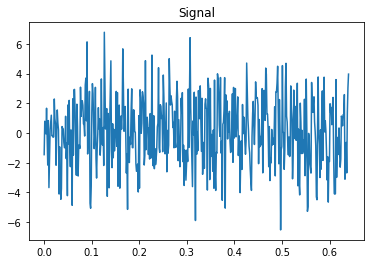

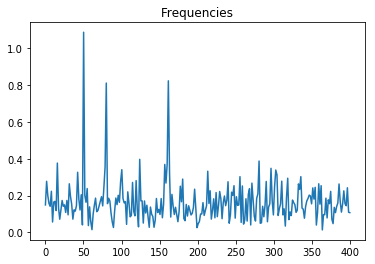

In [18]:
# Frecquency extraction
N = 2**9 # Number of samplepoints
T = 1.0 / 800.0 # sample spacing
x = np.linspace(0.0, N*T, N)
def signal(x):
    noise=np.random.normal(0, 2.0) # mean, var
    frequencies = [50, 80, 160]
    return noise + np.sum([np.sin(freq * 2.0*np.pi*x) for freq in frequencies])
data = [signal(x[i]) for i in range(len(x))]
yf = FFT(data)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

plt.plot(x, data)
plt.title("Signal")
plt.show()

plt.plot(xf, 2.0/N * np.abs(yf[:N//2])) # stem-plot also nice
plt.title("Frequencies")
plt.show()


  ## Mutliplication vs. Convolution (Faltung) in Time vs. Frequency Space
  Speedup in calculation..
  TODO: Explain

In [19]:
# FFT-Multiplication
a = [4,3,2,1,0,0,0,0] # a=1234
b = [8,7,6,5,0,0,0,0] # b=5678
af = FFT(a)
bf = FFT(b)
cf = np.multiply(af, bf)
c = IDFT(cf)
powers = [10**(i) for i in range(len(a))]
cNumber = int(np.round(np.dot(c,powers).real)) # Round off erros occur => round
print(cNumber)
print("FFT-multiplication error = ", 1234*5678 - cNumber)


7006652
FFT-multiplication error =  0


  ### Further Optimizations Possible!
  Link to other packages

In [20]:
# Speedtest
print("Compare our implementation with numpy:")
expo = 15
get_ipython().run_line_magic('time', 'FFT(np.random.rand(2**expo))')
get_ipython().run_line_magic('time', 'np.fft.fft(np.random.rand(2**expo))')
print("=> Numpy's np.fft.ftt is 1000x faster than ours 😒")



Compare our implementation with numpy:
CPU times: user 810 ms, sys: 10.2 ms, total: 820 ms
Wall time: 867 ms
CPU times: user 1.5 ms, sys: 100 µs, total: 1.6 ms
Wall time: 1.42 ms
=> Numpy's np.fft.ftt is 1000x faster than ours 😒
